In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import numpy as np
sns.set_theme()

In [2]:
RATIOS = [i/10.0 for i in range(1, 10)]
OURS_NAME_PAT = re.compile("logs/prunetimes\d_ratio([\d\.]+)_epochs")
L2_NAME_PAT = re.compile("logs/l2_prunetimes\d_ratio([\d\.]+)_epochs")
PARAM_PAT = re.compile("([\d\.]+) parameters out of [\d]+")
ACC_PAT = re.compile("Target Accuracy: \d+/\d+ \(([\d\.]+)\%\)")

In [3]:
RATIOS

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [4]:
def get_best_acc_final_param(file):
    accs = []
    param = 0
    for line in file.readlines():
        param_obj = PARAM_PAT.search(str(line))
        acc_obj = ACC_PAT.search(str(line))      
        if acc_obj is not None:
            accs.append(float(acc_obj.group(1)))
        if param_obj is not None:
            param = float(param_obj.group(1))
    return max(accs[-6:]), param

In [5]:
# Ours
def parse_method(PAT):
    directory = "logs/"
    params = []
    accs = []
    ratios = []
    for filename in os.listdir(directory):
        log_path = os.path.join(directory, filename)
        # checking if it is a file
        if not os.path.isfile(log_path):
            continue
        obj = PAT.search(str(log_path))
        if obj is not None:
            ratio = float(obj.group(1))
            if ratio not in RATIOS:
                continue
            with open(log_path, 'r') as f:
                acc, param = get_best_acc_final_param(f)
                accs.append(acc)
                params.append(param)
                ratios.append(ratio)

    x_names = [f"{x*100}%\n Params {y}" for x, y in zip(ratios, params)]
    x_names2 = [f"{x*100}%" for x, y in zip(ratios, params)]
    idxs = np.argsort(np.array(ratios))
    params = np.array(params)[idxs]
    accs = np.array(accs)[idxs]
    ratios = np.array(ratios)[idxs]
    x_names = np.array(x_names)[idxs]
    x_names2 = np.array(x_names2)[idxs]
    
    return params, accs, ratios, x_names, x_names2

In [6]:
params, accs, ratios, x_names, x_names2 = parse_method(OURS_NAME_PAT)
l2_params, l2_accs, l2_ratios, l2_x_names, l2_x_names2 = parse_method(L2_NAME_PAT)

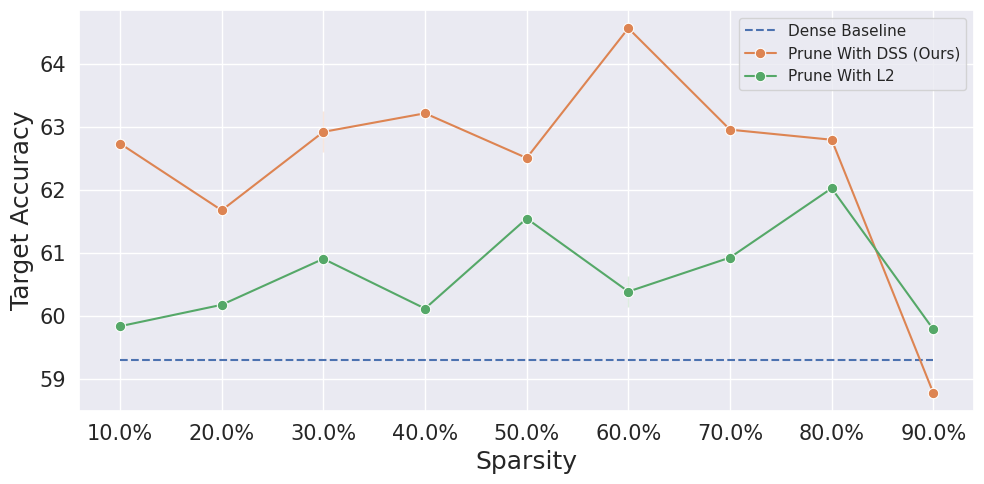

In [12]:
baselines = [59.30] * len(accs)
plt.figure(figsize = (10, 5))
sns.lineplot(x=x_names2, y=baselines, linestyle='--', label="Dense Baseline")
sns.lineplot(x=x_names2, y=accs, marker='.', markersize=15, label="Prune With DSS (Ours)")
sns.lineplot(x=l2_x_names2, y=l2_accs, marker='.', markersize=15, label="Prune With L2")
plt.xlabel("Sparsity", fontsize=18)
plt.ylabel("Target Accuracy", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("mnist_diffs.pdf")